In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Activation, BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [ ]:

def build_generator(z_dim):
  model = Sequential()

  model.add(Dense(7*7*256, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
  model.add(Activation('tanh'))

  return model

def build_discriminator(img_shape):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model


def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [ ]:

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

generator = build_generator(z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoint = []

def train(iterations, batch_size, sample_interval, save=True):
  (x_train, _), (_, _) = mnist.load_data()

  x_train = x_train / 127.5 - 1 # Normalization
  x_train = np.expand_dims(x_train, axis=3)
  
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]
    z = np.random.normal(0, 1, (batch_size, 100)) # Noise
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, acc = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)

    if (iteration+1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(acc)
      iteration_checkpoint.append(iteration+1)

      # print(f'{iteration+1} [D loss : {d_loss}, acc : {acc*100}] [G loss : {g_loss}]')

      sample_images(generator, iter=iteration,save=save)



def sample_images(generator, image_grid_rows =4, image_grid_colmuns=4, iter=0, save=False):
  z = np.random.normal(0, 1, (image_grid_rows*image_grid_colmuns, z_dim))
  gen_images = generator.predict(z)

  gen_images = 0.5 * gen_images + 0.5

  fig, axs = plt.subplots(image_grid_rows, image_grid_colmuns, figsize=(4,4), sharex=True, sharey=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_colmuns):
      axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

  if save==True:
    path = 'drive/My Drive/python/image/mnist_dcgan/'
    if not os.path.isdir(path):
      return 
    num = int((iter-4) / 5)
    name = "mnist-dcgan{0:05d}.jpg".format((num))
    fig.savefig(path+name)
      



In [ ]:
iterations =15000
batch_size=128
sample_interval = 5

train(iterations, batch_size, sample_interval)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


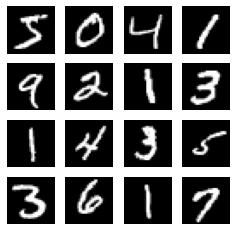

In [ ]:

(x, _), (_, _) = mnist.load_data()
idx = np.random.randint(0, x.shape[0], 16)
sample = x[idx]
fig, axis = plt.subplots(4, 4, figsize=(4,4), sharex=True, sharey=True)
cnt = 0
for i in range(4):
  for j in range(4):
    axis[i, j].imshow(x[cnt], cmap='gray')
    axis[i, j].axis('off')
    cnt += 1

In [ ]:
(x_train, y_train), (_, _) = mnist.load_data()


11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
y_train[:0]

array([], dtype=uint8)